# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=4)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=4)

In [4]:
# Definir a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 36)
        self.fc2 = nn.Linear(36, 10)
        self.activation_function = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP()
model.to(device)

print(model)

MLP(
  (fc1): Linear(in_features=1024, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [6]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.005, momentum=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


In [7]:
# Realizar o treinamento aqui

def train(epochs, validate=False):
    losses = []
    for epoch in range(epochs):
        print('Epoch ' + str(epoch + 1) + ':')
        train_sub_len = int(len(train_loader)/epochs)
        validate_indices = []
        if validate:
            start = epoch * train_sub_len
            end = (epoch + 1) * train_sub_len
            validate_indices = range(start, end)
            validate_set = list(train_loader) 
            
        correct = 0
        total = 0
        
        running_loss = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if not validate or i not in validate_indices:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

                running_loss += loss.item()
            
            if (i % train_sub_len == train_sub_len - 1) and (i not in validate_indices): 
                losses.append(running_loss / train_sub_len)
                running_loss = 0.0

                
        print('  Training accuracy: %d %%' % (
            100 * correct / total))
        
        if validate:
            correct = 0
            total = 0
            with torch.no_grad():
              for i in validate_indices:
                inputs, labels = validate_set[i]
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            print('  Validation accuracy: %d %%' % (
                    100 * correct / total))        
            
    plt.plot(losses)
    plt.title("Loss")
    plt.show()
            


Epoch 1:
  Training accuracy: 20 %
  Validation accuracy: 25 %
Epoch 2:
  Training accuracy: 27 %
  Validation accuracy: 30 %
Epoch 3:
  Training accuracy: 30 %
  Validation accuracy: 32 %
Epoch 4:
  Training accuracy: 32 %
  Validation accuracy: 35 %
Epoch 5:
  Training accuracy: 34 %
  Validation accuracy: 35 %
Epoch 6:
  Training accuracy: 35 %
  Validation accuracy: 37 %
Epoch 7:
  Training accuracy: 35 %
  Validation accuracy: 36 %
Epoch 8:
  Training accuracy: 36 %
  Validation accuracy: 38 %
Epoch 9:
  Training accuracy: 37 %
  Validation accuracy: 38 %
Epoch 10:
  Training accuracy: 37 %
  Validation accuracy: 37 %
Epoch 11:
  Training accuracy: 37 %
  Validation accuracy: 39 %
Epoch 12:
  Training accuracy: 38 %
  Validation accuracy: 38 %
Epoch 13:
  Training accuracy: 38 %
  Validation accuracy: 38 %
Epoch 14:
  Training accuracy: 38 %
  Validation accuracy: 36 %
Epoch 15:
  Training accuracy: 38 %
  Validation accuracy: 34 %
Epoch 16:
  Training accuracy: 39 %
  Validation 

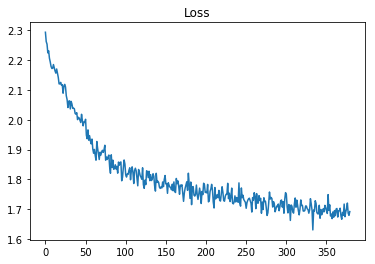

In [8]:
train(20, validate=True)

In [9]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

print('accuracy: %d %%' % (
    100 * correct / total))

accuracy: 37 %


In [10]:
# O modelo inicial teve uma arquitetura muito simples, utilizando otimização SGD e Cross Entropy como função loss, o que obteve melhores resultados no treinamento dentre as outras alternativas.
# Este primeiro modelo mostrou-se capaz de convergir para um erro menor do que o classificador utilizando apenas Perceptrons, embora demorasse um pouco mais para isso.
# Ao testar alterações na complexidade da rede, notou-se que aumentar a sua largura acelerava significativamente a convergência da mesma, ainda estagnando em máximos semelhantes.
# Por outro lado o aumento na profundidade pareceu piorar o aprendizado da rede.
# A troca da função de ativação Sigmoid pela ReLU melhorou ainda mais o treinamento da rede, apresentando saltos maiores a cada passo de aprendizado.
# A partir disto foram testadas diversas combinações de parâmetros até que se notou um overfit para o conjunto de treino, com bias muito elevado em relação ao conjunto de avaliação.
# Posteriormente, diminuiu-se a complexidade do modelo, o que resultou em acurácias com bias e variância menores, as quais são apresentadas acima.